In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
sns.set_context('poster', font_scale=1.25)

In [6]:
import findspark as fs

In [7]:
fs.init()

In [8]:
import pyspark as ps

In [11]:
config = ps.SparkConf()
config = config.setAppName('marvel_solver')

In [12]:
sc = ps.SparkContext(conf=config)

# Testing caching

In [20]:
muffin = sc.parallelize(range(100))

In [21]:
derp = muffin
for i in range(3):
    derp = derp.map(lambda x: x + 1)

In [23]:
derp.collect()

[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102]

Oh shit. That's how you do it. You *can* avoid collecting...shit

In [24]:
muffin.cache()

ParallelCollectionRDD[4] at parallelize at PythonRDD.scala:391

This does not do what we want sadly. We'll have to just apply a function every iteration and collect. Or else it's not gonna work.

In [25]:
muffin.cache()

ParallelCollectionRDD[4] at parallelize at PythonRDD.scala:391

In [26]:
wow = muffin.collect()

In [27]:
wow

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

# Graph work

In [28]:
marvel_raw_data = sc.textFile('marvel_data.csv')

In [29]:
marvel_raw_data.take(10)

[u'"FROST, CARMILLA","AA2 35"',
 u'"KILLRAVEN/JONATHAN R","AA2 35"',
 u'"M\'SHULLA","AA2 35"',
 u'"24-HOUR MAN/EMMANUEL","AA2 35"',
 u'"OLD SKULL","AA2 35"',
 u'"G\'RATH","AA2 35"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 35"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 36"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 37"',
 u'"HUMAN ROBOT","WI? 9"']

In [30]:
def get_issue_character(raw_line):
    dat = raw_line.split('"')
    character_name = dat[1]
    issue = dat[3]
    return (issue, character_name)

In [31]:
issue_character_rdd = marvel_raw_data.map(get_issue_character)

Links are symmetric. We can just create key/value pairs from this. We want character as a key, values as everyone they link to. If one character links to another, the other character *must* link to them!

In [32]:
issue_groups_rdd = issue_character_rdd.groupByKey()

In [33]:
muffin = [(2,3),(4,5)]

In [34]:
def get_links_from_groups(x):
    list_of_characters = list(x[1])
    links = []
    for cur_character in list_of_characters:
        for other_character in list_of_characters:
            if cur_character != other_character:
                # Ensure that links are symmetric
                links.append((cur_character, other_character))
                links.append((other_character, cur_character))
    return tuple(links)

In [35]:
all_links_rdd = issue_groups_rdd.flatMap(get_links_from_groups)

We now groupby key again. And then we have all the links for a given individual. *But* we have to make sure they are unique.

In [36]:
all_links_rdd.take(2)

[(u'PRINCESS ZANDA', u"BLACK PANTHER/T'CHAL"),
 (u"BLACK PANTHER/T'CHAL", u'PRINCESS ZANDA')]

In [37]:
character_and_links_rdd = all_links_rdd.groupByKey()

In [38]:
def cleanup_links(x):
    linked_to = list(x[1])
    unique_links = tuple(set(linked_to))
    return (x[0], unique_links)

In [39]:
character_and_links_rdd.take(1)

[(u'QUESADA, JOE', <pyspark.resultiterable.ResultIterable at 0x7fece5364b10>)]

In [40]:
network_rdd = character_and_links_rdd.map(cleanup_links)

Ok, awesome. We are all set.

In [41]:
network_result = network_rdd.collect()

In [42]:
network_result[0:5]

[(u'QUESADA, JOE',
  (u'ZURI',
   u'GLADIATOR/MELVIN POT',
   u'SMITH, KEVIN',
   u'OKOYE',
   u'PALMIOTTI, JIMMY',
   u'MARTINEZ, ALITHA',
   u'MYSTERIO/QUENTIN BEC',
   u'WATSON-PARKER, MARY ',
   u'SPIDER-MAN/PETER PAR',
   u'MCKENZIE, LYDIA',
   u'LAMY, KELLY',
   u'URICH, BEN',
   u"BLACK PANTHER/T'CHAL",
   u'MR. FANTASTIC/REED R',
   u'THING/BENJAMIN J. GR',
   u'QUINN, ASHLEY',
   u'CAPTAIN AMERICA',
   u'MALICE V/NAKIA',
   u'NELSON, CANDACE',
   u'INVISIBLE WOMAN/SUE ',
   u'BUTCH',
   u'EIGHTBALL',
   u'DAREDEVIL/MATT MURDO',
   u'ROSS, EVERETT KENNET',
   u'POTTER, BETSY BEATTY',
   u'BLACK WIDOW/NATASHA ',
   u'EVERETT, BILL',
   u'BLAKE, BECKY',
   u'DAKESIAN, NANCI',
   u'SHARPE, ROSALINDE',
   u'NELSON, FRANKLIN FOG',
   u'MILLER, FRANK',
   u'HUMAN TORCH/JOHNNY S',
   u'OSBORN, LIZ ALLAN',
   u'DR. STRANGE/STEPHEN ',
   u'DARLA',
   u'RALF',
   u'PAGE, KAREN',
   u'LEE, STAN')),
 (u'CRUSADER II/ARTHUR B',
  (u'HELA [ASGARDIAN]',
   u'X-MAN/NATHAN GREY ',
   u'HOGUN [AS

## One iteration

In [33]:
start_node = 'CAPTAIN AMERICA'

In [34]:
network_to_touch = network_rdd.filter(lambda x: x[0] == start_node)
print network_to_touch.take(1)

[(u'CAPTAIN AMERICA', (u'QUESADA, JOE', u'SILVER SAMURAI/KENYU', u'CAPTAIN AMERICA IV/S', u'DREAMING CELESTIAL/T', u'VOGHT, AMELIA', u'KRO [DEVIANT]', u'PHASTOS [ETERNAL]', u'PUCK DOPPELGANGER', u'POPE', u'POWER PRINCESS/ZARDA', u'MODRED THE MYSTIC', u"JACK O'LANTERN II/MA", u'DR. FAUSTUS', u'GHOST GIRL/', u'HESCAMAR/MARNOT [ASG', u'LORD TEMPLAR/', u'RODGERS, MARIANNE', u'HIJACKER', u'HOCHBERG, ROGER', u'MARROW/SARAH ', u'EPOCH', u'MOTHER NIGHT/SUSAN S', u'PIECEMEAL/GILBERT BE', u'OMNIBUS/LT. DALLAS', u'SHAKTI', u'WHIZZER III/JAMES SA', u'KORATH THE PURSUER', u'WOLFE, HEDY', u'WOLF SPIRIT/OWAYODAT', u'PEREGRINE, LE/FRANCK', u'STRUCKER, ANDREA', u'MARTHA', u'MAGUS', u'DOLLAR BILL', u'MANTIS/? BRANDT', u'CARBON', u'KNIGHT ERRANT/MATSON', u'STUNT-MASTER/GEORGE ', u'NEKRA/ADRIENNE HATRO', u'WHITMAN, DEBRA', u'BRADDOCK, JAMES JR. ', u'DUNER, MAJOR', u'ACHEBE, REVEREND DOC', u'MALICE V/NAKIA', u'BERDITCHEV, ITZHAK', u'SANTINI, DR. JOSE', u'PIPER', u'CAT MAN III/', u'JAMESON, J. JONAH', u'CAP

In [35]:
distance_rdd = network_to_touch.map(lambda x: (x[0], 0))

In [36]:
nodes_to_touch = network_to_touch.flatMap(lambda x: x[1])

In [37]:
unique_nodes_to_touch = nodes_to_touch.distinct()

Now append these to the distance_rdd. 

In [38]:
updated_touched_nodes = unique_nodes_to_touch.map(lambda x: (x, 1))

In [39]:
updated_touched_nodes.take(5)

[(u'QUESADA, JOE', 1),
 (u'PARKER, MAY | TIMESL', 1),
 (u'SILVER SAMURAI/KENYU', 1),
 (u'STORM, CHILI', 1),
 (u'JESTER III', 1)]

In [40]:
updated_distance_rdd = distance_rdd.union(updated_touched_nodes)

In [41]:
updated_distance_rdd.take(5)

[(u'CAPTAIN AMERICA', 0),
 (u'QUESADA, JOE', 1),
 (u'PARKER, MAY | TIMESL', 1),
 (u'SILVER SAMURAI/KENYU', 1),
 (u'STORM, CHILI', 1)]

We now reduce by key!

In [42]:
def get_smaller_value(a, b):
    if a < b:
        return a
    else:
        return b

In [43]:
corrected_distance_rdd = updated_distance_rdd.reduceByKey(get_smaller_value)

In [44]:
muffin = corrected_distance_rdd.collectAsMap()

Now we have to apply this a bunch of times. Then we are all set. The piece I was missing was reduce by key.

Let's make a class to handle this. Let's make that class in a separate file and import it or it's going to be very annoying.

Also, let's figure out how to join the distance rdd to what we need.

In [45]:
already_touched_rdd = corrected_distance_rdd.map(lambda x: x[0])
already_touched = already_touched_rdd.collect()

In [46]:
already_touched_set = set(already_touched)

In [47]:
broadcasted_touched = sc.broadcast(already_touched_set)

In [48]:
network_to_touch = network_rdd.filter(lambda x: x[0] in broadcasted_touched.value)

This is a good way to do it and avoids a nasty join.

In [84]:
derp = sc.parallelize([('a', 'b')])

In [85]:
derp.collect()

[('a', 'b')]

# Applying my class

This makes no sense. Can we run the eval function instead of importing...?

In [87]:
from HW1.network_commands import BFS

## Captain America

In [95]:
searcher = BFS(sc, 'CAPTAIN AMERICA', network_rdd)

In [96]:
for i in range(10):
    searcher.do_iteration()

In [98]:
captain_america_result = searcher.distance_rdd.collect()

In [99]:
derp = dict(captain_america_result)

In [101]:
muffin = dict(captain_america_result)

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.90600000e+03,   0.00000000e+00,   0.00000000e+00,
          4.46300000e+03,   0.00000000e+00,   0.00000000e+00,
          3.80000000e+01]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

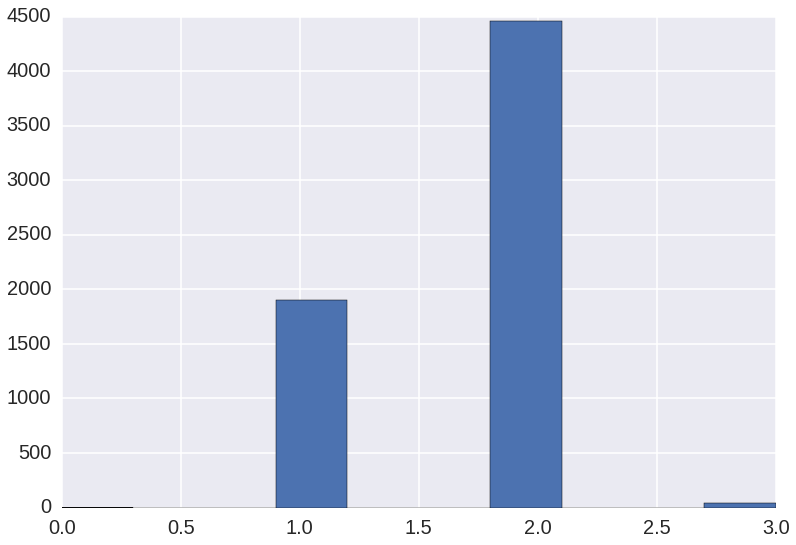

In [102]:
plt.hist(muffin.values())

Cool. The number of nodes touched are

In [52]:
len(muffin)

6408

## Miss Thing/Mary

In [73]:
searcher = BFS(sc, 'MISS THING/MARY', network_rdd)

In [74]:
for i in range(10):
    searcher.do_iteration()

In [75]:
thing_list = searcher.collected_distance_rdd

In [77]:
muffin = dict(thing_list)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

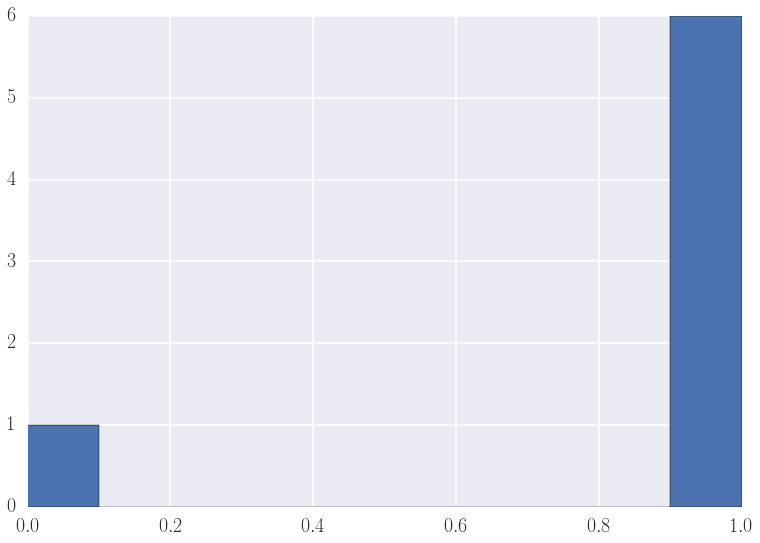

In [78]:
plt.hist(muffin.values())

In [79]:
len(muffin)

7

## Orwell

In [80]:
searcher = BFS(sc, 'ORWELL', network_rdd)

In [81]:
for i in range(10):
    searcher.do_iteration()

In [82]:
orwell_list = searcher.collected_distance_rdd

In [84]:
muffin = dict(orwell_list)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

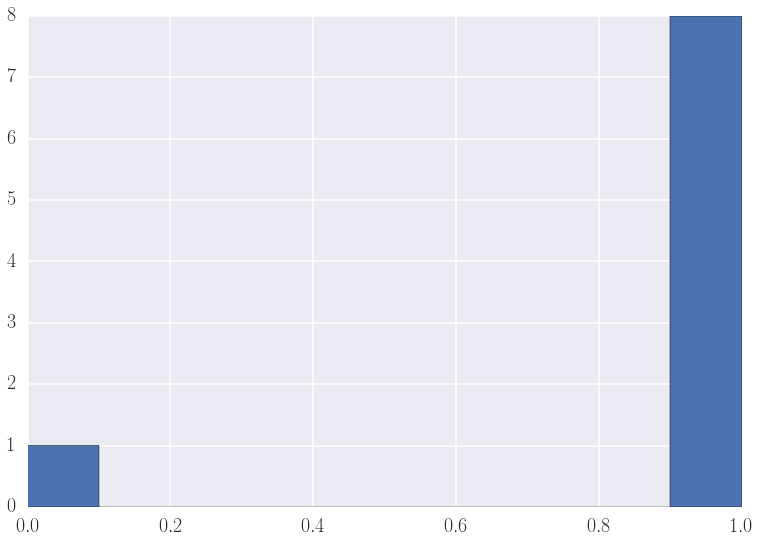

In [85]:
plt.hist(muffin.values())

In [86]:
len(orwell_list)

9

In [87]:
orwell_list

[(u'NILES, SEN. CATHERIN', 1),
 (u'ASHER, CARL', 1),
 (u'LUDLUM, ROSS', 1),
 (u'ASHER, MICHAEL', 1),
 (u'ORWELL', 0),
 (u'OSWALD', 1),
 (u'FAGIN', 1),
 (u'HOFFMAN', 1),
 (u'ASHER, DONNA', 1)]

Well, I think this is the first part of the problem. I don't really understand how to optimize with accumulators though. Also, let us write code to make the network converge.

In [113]:
network_rdd = network_rdd.cache()

In [116]:
network_rdd.is_cached

True

# Running until converged

In [117]:
searcher = BFS(sc, 'CAPTAIN AMERICA', network_rdd)

In [118]:
searcher.run_until_converged()

Finished at end of iteration 4 !


In [103]:
searcher = BFS(sc, 'ORWELL', network_rdd)

In [104]:
searcher.run_until_converged()

Finished at end of iteration 2 !


In [92]:
a={'a':1, 'b':2, 'c':3}
b = {'c':2, 'b':2, 'a':1, 'd':69}

In [ ]:
assert cmp